In [1]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "mathtext.fontset": "cm",
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"]
    #"font.family": "sans-serif",
    #"font.sans-serif": ["Computer Modern Serif"]
})
import tqdm
import sys
sys.path.append("../../")
sys.path.append("experiments/")
from DynamicalSystems.kernels import RBF, Quadratic, Linear, Matern
from DynamicalSystems.reduced_rank_regression import KoopmanRegression
from DynamicalSystems.utils import plot_eigs
import seaborn as sns
from common_utils import *

#### Standardizing dataset

In [2]:
df, measurements, standardizing_parameters = prepare_dataset('full_dataframe')

#### Selecting timestep, kernel, desired rank & regularizer

In [47]:
n_timesteps = 3 #In hours
regularizer = 3e-5
history = 9
average = False
_df, features_names = get_training_dataset(df, measurements, n_timesteps = n_timesteps, history = history, average = average)
l = np.float32(np.sqrt(_df.shape[1]))*3
X, Y = _df[:-1], _df[1:]
nu = 0.5
kernel = Matern(nu = nu, length_scale=l)
#kernel = Linear(coef0=0.)
num_samples = 5000
rank = 20
X_train, Y_train = X[:num_samples], Y[:num_samples]

In [48]:
K_pcr = KoopmanRegression(X_train, Y_train, kernel, regularizer, rank=rank, center_kernel=False, backend='cpu', rank_reduction='pcr')
K_full = KoopmanRegression(X_train, Y_train, kernel, regularizer, rank=None, center_kernel=False, backend='cpu', rank_reduction='pcr')

INIT: Computing low-rank-projection via Principal Component Regression


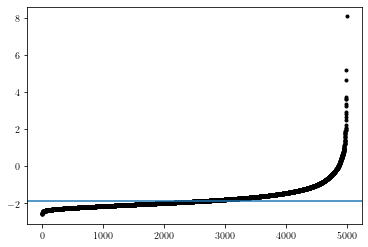

In [51]:
plt.plot(np.log(np.abs(np.linalg.eigvalsh(K_full.K_X))), 'k.')
plt.axhline(np.log(regularizer*num_samples))

### Forecasting

In [66]:
idx_0 = num_samples - 25
x_pred = []
x_pcr = []
x_r3 = []
n_steps = 100
x_true = Y[idx_0:(idx_0 + n_steps + 1)]
K_pcr.eig()
evolve_pcr = K_pcr.modal_decompostion()
forward_steps = 1
for i in tqdm.tqdm(range(n_steps)):
    if i%forward_steps == 0:
        x_pred.append(K_full.forecast(x_true[i]))    
        #x_pcr.append(evolve_pcr(x_true[i], np.array([1])))
        x_pcr.append(K_pcr.forecast(x_true[i]))
    else:
        x_pred.append(K_full.forecast(x_pred[-1]))
        #x_pcr.append(evolve_pcr(x_pred[-1], np.array([1])))
        x_pcr.append(K_pcr.forecast(x_pred[-1]))
        
x_pred = np.array(x_pred)
x_pcr = np.squeeze(np.array(x_pcr))/num_samples
x_true = x_true[1:]

100%|██████████| 100/100 [00:03<00:00, 32.45it/s]


In [ ]:
def forecast_error(x_true, )

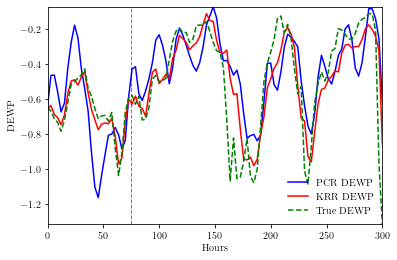

In [57]:
measurement = 'DEWP'

data = [x_pcr, x_pred, x_true]
labels = ['PCR', 'KRR', 'True']
colors = ['b-', 'r-', 'g--']
fig, ax = plt.subplots()
def plot_forecast(ax, x, label, color):
    m = mask_old_timesteps(x, features_names, measurement, history)
    hours = np.linspace(0, n_steps*n_timesteps, n_steps)
    #ax.plot(hours, m, color, alpha = 0.3, lw=0.3)
    ax.plot(hours, m.mean(axis=1), color, label=label + ' ' + measurement)

for i in range(len(data)):
    plot_forecast(ax, data[i], labels[i], colors[i])
ax.axvline(x=n_timesteps*25, color='k', linestyle='--', lw=1, alpha = 0.5)
#plt.text(x=n_timesteps*25 + 3, y = -2, s='UNSEEN DATA', rotation='vertical', fontsize=8, verticalalignment='bottom')
ax.set_ylabel(measurement)
ax.set_xlabel('Hours')
ax.margins(0)
ax.legend(frameon=False)
#plt.savefig("figs/predictions_" + measurement + ".pdf", bbox_inches='tight')

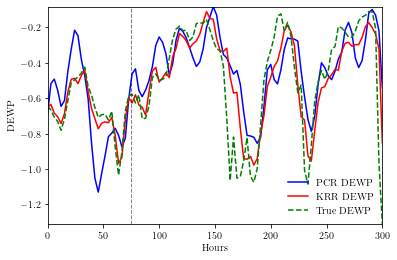

In [67]:
measurement = 'DEWP'

data = [x_pcr, x_pred, x_true]
labels = ['PCR', 'KRR', 'True']
colors = ['b-', 'r-', 'g--']
fig, ax = plt.subplots()
def plot_forecast(ax, x, label, color):
    m = mask_old_timesteps(x, features_names, measurement, history)
    hours = np.linspace(0, n_steps*n_timesteps, n_steps)
    #ax.plot(hours, m, color, alpha = 0.3, lw=0.3)
    ax.plot(hours, m.mean(axis=1), color, label=label + ' ' + measurement)

for i in range(len(data)):
    plot_forecast(ax, data[i], labels[i], colors[i])
ax.axvline(x=n_timesteps*25, color='k', linestyle='--', lw=1, alpha = 0.5)
#plt.text(x=n_timesteps*25 + 3, y = -2, s='UNSEEN DATA', rotation='vertical', fontsize=8, verticalalignment='bottom')
ax.set_ylabel(measurement)
ax.set_xlabel('Hours')
ax.margins(0)
ax.legend(frameon=False)
#plt.savefig("figs/predictions_" + measurement + ".pdf", bbox_inches='tight')

### Eigenvalue approximation

In [139]:
#Full approximation
dim = K.K_X.shape[0]
eigs_full = scipy.linalg.eigvals(K.K_YX, K.K_X + dim*regularizer*np.eye(dim))
#Reduced rank regression
eigs_RRR, _, _ = K.eig() 
#Dynamic Mode decomposition
U_r, S_r, V_r = np.linalg.svd(K.K_X)
K_r = U_r[:, :rank]@np.diag(S_r[:rank])@V_r[:rank, :]
eigs_DMD = scipy.linalg.eigvals(scipy.linalg.pinv(K_r)@K.K_YX)

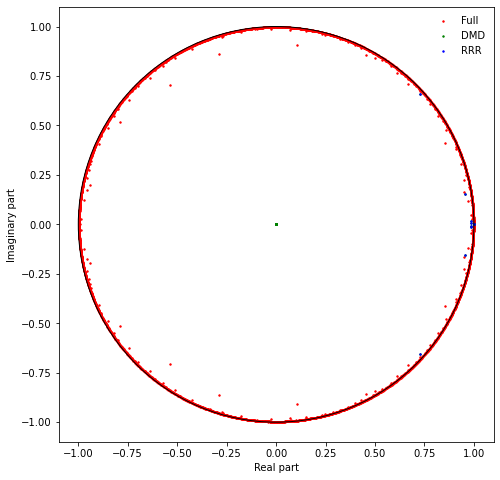

In [140]:
fig, ax = plot_eigs([eigs_full, eigs_DMD, eigs_RRR], labels=['Full', 'DMD', 'RRR'])
#ax.set_xlim(0.7,1)

In [141]:
print_timescale(eigs_RRR, n_timesteps, 1, 'Hours')

Decay: 148.05 Hours     Frequency: 25.66 Hours
Decay: 84.69 Hours      Frequency: 117.3 Hours
Decay: 214.14 Hours     Frequency: 1184.32 Hours
Decay:116675.96 Hours
Decay:1684.66 Hours
Decay: 188.18 Hours     Frequency: 2942.08 Hours


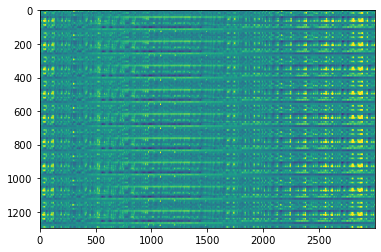

In [142]:
plt.imshow(X_train.T,aspect='auto', vmin=-3, vmax=3)

### Mode decomposition

In [143]:
modes = K.modes()
eigs = K.eigvals()
obs_1 = "PM2.5"
obs_2 = "DEWP"
modes_1 = mask_old_timesteps(modes, obs_1, history)
modes_2 = mask_old_timesteps(modes, obs_2, history)
modes_1_avg = modes_1.mean(axis=1)
modes_2_avg = modes_2.mean(axis=1)
c_1 = 'r'
c_2 = 'b'

Text(0.5, 1.0, 'Similar amplitudes suggest similar modes')

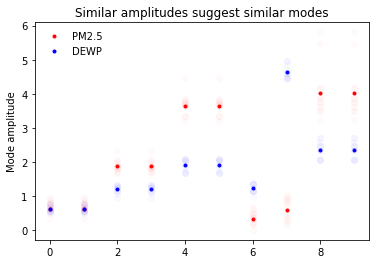

In [144]:
plt.plot(np.abs(modes_1),c_1+'o', alpha=0.02);
plt.plot(np.abs(modes_2),c_2+'o', alpha=0.02);
plt.plot(np.abs(modes_1_avg),c_1+'.', label=obs_1);
plt.plot(np.abs(modes_2_avg),c_2+'.', label=obs_2);
plt.legend(frameon=False)
plt.ylabel("Mode amplitude")
plt.title("Similar amplitudes suggest similar modes")

In [196]:
def causality_rel(idx, eigs, modes_1_avg, modes_2_avg, obs_1, obs_2, stride, n_timesteps, units):
    dphi = np.sign(eigs.imag)*(np.angle(modes_2_avg) - np.angle(modes_1_avg))
    dphi = dphi - np.pi*2*np.floor((dphi + np.pi)/(2*np.pi))
    
    if np.abs(dphi[idx]) < 1e-12:
        print(f"{obs_1} and {obs_2} are in phase")
    elif np.abs(np.abs(dphi[idx]) - np.pi) < 1e-12:
        print(f"{obs_1} and {obs_2} are anti-phase")
    elif dphi[idx] > 0:
        dt = np.around(stride*n_timesteps*dphi[idx]/np.abs(np.angle(eigs[idx])), decimals=2)
        print(f"{obs_2} comes first than {obs_1} by {dt} {units}")
    else:
        dt = np.around(stride*n_timesteps*dphi[idx]/np.abs(np.angle(eigs[idx])), decimals=2)
        print(f"{obs_1} comes first than {obs_2} by {-dt} {units}")
    return dphi

In [197]:
idx = 0
dphi = causality_rel(idx, eigs, modes_1_avg, modes_2_avg, obs_1, obs_2, 1, n_timesteps, 'Hours')

DEWP comes first than PM2.5 by 4.01 Hours


Text(0.5, 0, 'Time')

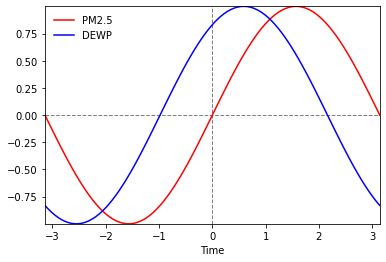

In [193]:
x = np.linspace(-np.pi, np.pi ,100)
phi = dphi[idx]
plt.axvline(x=0, color='k', linestyle='--', lw=1, alpha = 0.5)
plt.axhline(y=0, color='k', linestyle='--', lw=1, alpha = 0.5)
plt.plot(x, np.sin(x), c_1, label=obs_1)
plt.plot(x, np.sin(phi + x), c_2, label=obs_2)
plt.legend(frameon=False)
plt.margins(0)
plt.xlabel("Time")